In [ ]:
import torch, math, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from scipy.stats import kde
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import DataLoader
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 170498071/170498071 [00:10<00:00, 16388001.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def train(model, device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward(retain_graph=True)
        optimizer.step()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy, test_loss


In [ ]:
#take batch norm implementation from the example given and edit it to include the change proposed
#remove gamma, add alpha

def batch_norm(X, beta, moving_mean, moving_var, moving_std, eps, momentum, alpha):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)

        std = torch.sqrt(var + eps)
        new_std = alpha * moving_std + (1 - alpha) * std #here is the weighted average std
        X_hat = (X - mean) / new_std

        moving_mean = (1 - momentum) * moving_mean + momentum * mean
        moving_var = (1 - momentum) * moving_var + momentum * var
        moving_std = (1 - momentum) * moving_std + momentum * std

    Y = X_hat + beta
    return Y, moving_mean.data, moving_var.data, moving_std.data

class CustomBatchNorm(nn.Module):
    def __init__(self, num_features, num_dims, alpha=0.5):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)

        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        self.moving_std = torch.sqrt(self.moving_var)
        self.alpha = alpha

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
            self.moving_std = self.moving_std.to(X.device)

        Y, self.moving_mean, self.moving_var, self.moving_std = batch_norm(
            X, self.beta, self.moving_mean, self.moving_var,
            self.moving_std, eps=1e-5, momentum=0.1, alpha=self.alpha)
        return Y


In [ ]:
#Create the new model with new batch norm, alpha at 0.5 as a standard

class NewModel(nn.Module):
    def __init__(self, alpha):
        super(NewModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), CustomBatchNorm(64,4, alpha),nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), CustomBatchNorm(64,4, alpha), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), CustomBatchNorm(128,4, alpha), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), CustomBatchNorm(128,4, alpha), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), CustomBatchNorm(256,4, alpha), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), CustomBatchNorm(256,4, alpha), nn.ReLU(),
            nn.MaxPool2d(2),nn.Flatten(), nn.Linear(4096, 512), nn.Dropout(0.5),
            nn.Linear(512, 256),nn.Dropout(0.5), nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.model(x)





In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewModel(alpha = 0.5).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

target_accuracy = 87
epochs = 0
accuracy = 0
epoch_limit = 50
new_loss_list = []
new_test_accuracy = []

torch.cuda.empty_cache()
while accuracy < target_accuracy and epochs <= epoch_limit:
    epochs += 1
    train(model, device, train_loader, optimizer)
    accuracy, test_loss = test(model, device, test_loader)
    new_test_accuracy.append(accuracy)
    new_loss_list.append(test_loss)
    print(f'Epoch: {epochs}, Test Accuracy: {accuracy:.2f}%')

print(f'Converged in {epochs} epochs')


Epoch: 1, Test Accuracy: 65.93%
Epoch: 2, Test Accuracy: 76.44%
Epoch: 3, Test Accuracy: 80.77%
Epoch: 4, Test Accuracy: 80.49%
Epoch: 5, Test Accuracy: 82.96%
Epoch: 6, Test Accuracy: 82.09%
Epoch: 7, Test Accuracy: 83.74%
Epoch: 8, Test Accuracy: 82.82%
Epoch: 9, Test Accuracy: 84.43%
Epoch: 10, Test Accuracy: 84.01%
Epoch: 11, Test Accuracy: 83.79%
Epoch: 12, Test Accuracy: 84.73%
Epoch: 13, Test Accuracy: 84.56%
Epoch: 14, Test Accuracy: 84.64%
Epoch: 15, Test Accuracy: 83.98%
Epoch: 16, Test Accuracy: 84.49%
Epoch: 17, Test Accuracy: 85.52%
Epoch: 18, Test Accuracy: 85.03%
Epoch: 19, Test Accuracy: 84.94%
Epoch: 20, Test Accuracy: 85.37%
Epoch: 21, Test Accuracy: 83.72%
Epoch: 22, Test Accuracy: 84.63%
Epoch: 23, Test Accuracy: 84.88%
Epoch: 24, Test Accuracy: 85.52%
Epoch: 25, Test Accuracy: 84.59%
Epoch: 26, Test Accuracy: 84.79%
Epoch: 27, Test Accuracy: 85.19%
Epoch: 28, Test Accuracy: 84.99%
Epoch: 29, Test Accuracy: 85.15%
Epoch: 30, Test Accuracy: 85.27%
Epoch: 31, Test Acc

In [ ]:
#testing alpha = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewModel(alpha = 0.1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

target_accuracy = 87
epochs = 0
accuracy = 0
epoch_limit = 50
loss_list_0_1 = []
test_accuracy_0_1 = []

torch.cuda.empty_cache()
while accuracy < target_accuracy and epochs <= epoch_limit:
    epochs += 1
    train(model, device, train_loader, optimizer)
    accuracy, test_loss = test(model, device, test_loader)
    test_accuracy_0_1.append(accuracy)
    loss_list_0_1.append(test_loss)
    print(f'Epoch: {epochs}, Test Accuracy: {accuracy:.2f}%')

print(f'Converged in {epochs} epochs')


Epoch: 1, Test Accuracy: 58.79%
Epoch: 2, Test Accuracy: 70.35%
Epoch: 3, Test Accuracy: 77.79%
Epoch: 4, Test Accuracy: 77.20%
Epoch: 5, Test Accuracy: 81.99%
Epoch: 6, Test Accuracy: 82.93%
Epoch: 7, Test Accuracy: 77.96%
Epoch: 8, Test Accuracy: 84.87%
Epoch: 9, Test Accuracy: 82.77%
Epoch: 10, Test Accuracy: 83.75%
Epoch: 11, Test Accuracy: 84.57%
Epoch: 12, Test Accuracy: 83.12%
Epoch: 13, Test Accuracy: 84.66%
Epoch: 14, Test Accuracy: 84.05%
Epoch: 15, Test Accuracy: 83.01%
Epoch: 16, Test Accuracy: 84.67%
Epoch: 17, Test Accuracy: 84.64%
Epoch: 18, Test Accuracy: 84.11%
Epoch: 19, Test Accuracy: 83.07%
Epoch: 20, Test Accuracy: 78.53%
Epoch: 21, Test Accuracy: 84.91%
Epoch: 22, Test Accuracy: 84.03%
Epoch: 23, Test Accuracy: 84.10%
Epoch: 24, Test Accuracy: 84.29%
Epoch: 25, Test Accuracy: 84.54%
Epoch: 26, Test Accuracy: 84.26%
Epoch: 27, Test Accuracy: 83.63%
Epoch: 28, Test Accuracy: 83.53%
Epoch: 29, Test Accuracy: 83.45%
Epoch: 30, Test Accuracy: 84.94%
Epoch: 31, Test Acc

In [ ]:
#testing alpha = 0.25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewModel(alpha = 0.25).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

target_accuracy = 87
epochs = 0
accuracy = 0
epoch_limit = 50
loss_list_0_1 = []
test_accuracy_0_1 = []

torch.cuda.empty_cache()
while accuracy < target_accuracy and epochs <= epoch_limit:
    epochs += 1
    train(model, device, train_loader, optimizer)
    accuracy, test_loss = test(model, device, test_loader)
    test_accuracy_0_1.append(accuracy)
    loss_list_0_1.append(test_loss)
    print(f'Epoch: {epochs}, Test Accuracy: {accuracy:.2f}%')

print(f'Converged in {epochs} epochs')


Epoch: 1, Test Accuracy: 64.62%
Epoch: 2, Test Accuracy: 73.16%
Epoch: 3, Test Accuracy: 78.26%
Epoch: 4, Test Accuracy: 79.86%
Epoch: 5, Test Accuracy: 82.23%
Epoch: 6, Test Accuracy: 82.13%
Epoch: 7, Test Accuracy: 83.25%
Epoch: 8, Test Accuracy: 84.05%
Epoch: 9, Test Accuracy: 83.95%
Epoch: 10, Test Accuracy: 83.53%
Epoch: 11, Test Accuracy: 84.61%
Epoch: 12, Test Accuracy: 83.22%
Epoch: 13, Test Accuracy: 84.29%
Epoch: 14, Test Accuracy: 83.86%
Epoch: 15, Test Accuracy: 81.81%
Epoch: 16, Test Accuracy: 83.35%
Epoch: 17, Test Accuracy: 84.33%
Epoch: 18, Test Accuracy: 84.43%
Epoch: 19, Test Accuracy: 84.50%
Epoch: 20, Test Accuracy: 84.71%
Epoch: 21, Test Accuracy: 83.07%
Epoch: 22, Test Accuracy: 84.69%
Epoch: 23, Test Accuracy: 85.06%
Epoch: 24, Test Accuracy: 85.54%
Epoch: 25, Test Accuracy: 84.61%
Epoch: 26, Test Accuracy: 84.54%
Epoch: 27, Test Accuracy: 83.78%
Epoch: 28, Test Accuracy: 84.37%
Epoch: 29, Test Accuracy: 84.87%
Epoch: 30, Test Accuracy: 84.47%
Epoch: 31, Test Acc

In [ ]:
#testing alpha = 0.75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewModel(alpha = 0.75).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

target_accuracy = 87
epochs = 0
accuracy = 0
epoch_limit = 50
loss_list_0_75 = []
test_accuracy_0_75 = []

torch.cuda.empty_cache()
while accuracy < target_accuracy and epochs <= epoch_limit:
    epochs += 1
    train(model, device, train_loader, optimizer)
    accuracy, test_loss = test(model, device, test_loader)
    test_accuracy_0_75.append(accuracy)
    loss_list_0_75.append(test_loss)
    print(f'Epoch: {epochs}, Test Accuracy: {accuracy:.2f}%')

print(f'Converged in {epochs} epochs')


Epoch: 1, Test Accuracy: 60.38%
Epoch: 2, Test Accuracy: 64.41%
Epoch: 3, Test Accuracy: 69.00%
Epoch: 4, Test Accuracy: 64.22%
Epoch: 5, Test Accuracy: 70.37%
Epoch: 6, Test Accuracy: 64.98%
Epoch: 7, Test Accuracy: 63.59%
Epoch: 8, Test Accuracy: 65.80%
Epoch: 9, Test Accuracy: 61.74%
Epoch: 10, Test Accuracy: 26.17%
Epoch: 11, Test Accuracy: 46.47%
Epoch: 12, Test Accuracy: 56.18%
Epoch: 13, Test Accuracy: 48.15%
Epoch: 14, Test Accuracy: 67.55%
Epoch: 15, Test Accuracy: 69.44%
Epoch: 16, Test Accuracy: 70.91%
Epoch: 17, Test Accuracy: 71.92%
Epoch: 18, Test Accuracy: 74.74%
Epoch: 19, Test Accuracy: 65.35%
Epoch: 20, Test Accuracy: 75.86%
Epoch: 21, Test Accuracy: 75.84%
Epoch: 22, Test Accuracy: 75.18%
Epoch: 23, Test Accuracy: 73.99%
Epoch: 24, Test Accuracy: 75.97%
Epoch: 25, Test Accuracy: 76.09%
Epoch: 26, Test Accuracy: 76.49%
Epoch: 27, Test Accuracy: 76.75%
Epoch: 28, Test Accuracy: 77.42%
Epoch: 29, Test Accuracy: 75.66%
Epoch: 30, Test Accuracy: 76.57%
Epoch: 31, Test Acc

In [ ]:
#testing alpha = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewModel(alpha = 0.9).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

target_accuracy = 87
epochs = 0
accuracy = 0
epoch_limit = 50
loss_list_0_75 = []
test_accuracy_0_75 = []

torch.cuda.empty_cache()
while accuracy < target_accuracy and epochs <= epoch_limit:
    epochs += 1
    train(model, device, train_loader, optimizer)
    accuracy, test_loss = test(model, device, test_loader)
    test_accuracy_0_75.append(accuracy)
    loss_list_0_75.append(test_loss)
    print(f'Epoch: {epochs}, Test Accuracy: {accuracy:.2f}%')

print(f'Converged in {epochs} epochs')


Epoch: 1, Test Accuracy: 60.33%
Epoch: 2, Test Accuracy: 55.03%
Epoch: 3, Test Accuracy: 60.68%
Epoch: 4, Test Accuracy: 14.47%
Epoch: 5, Test Accuracy: 18.44%
Epoch: 6, Test Accuracy: 19.81%
Epoch: 7, Test Accuracy: 20.71%
Epoch: 8, Test Accuracy: 20.70%
Epoch: 9, Test Accuracy: 21.27%
Epoch: 10, Test Accuracy: 21.87%
Epoch: 11, Test Accuracy: 22.60%
Epoch: 12, Test Accuracy: 25.44%
Epoch: 13, Test Accuracy: 27.34%
Epoch: 14, Test Accuracy: 11.23%
Epoch: 15, Test Accuracy: 17.12%
Epoch: 16, Test Accuracy: 10.66%
Epoch: 17, Test Accuracy: 18.08%
Epoch: 18, Test Accuracy: 15.92%
Epoch: 19, Test Accuracy: 22.98%
Epoch: 20, Test Accuracy: 24.08%
Epoch: 21, Test Accuracy: 26.25%
Epoch: 22, Test Accuracy: 14.96%
Epoch: 23, Test Accuracy: 20.70%
Epoch: 24, Test Accuracy: 23.01%
Epoch: 25, Test Accuracy: 23.87%
Epoch: 26, Test Accuracy: 25.12%
Epoch: 27, Test Accuracy: 27.34%
Epoch: 28, Test Accuracy: 12.69%
Epoch: 29, Test Accuracy: 17.33%
Epoch: 30, Test Accuracy: 21.10%
Epoch: 31, Test Acc

In [ ]:
test_accuracy_0_9 = [60.33, 55.03, 60.68, 14.47, 18.44, 19.81, 20.71, 20.7, 21.27, 21.87, 22.6, 25.44, 27.34, 11.23, 17.12, 10.66, 18.08, 15.92, 22.98, 24.08, 26.25, 14.96, 20.7, 23.01, 23.87, 25.12, 27.34, 12.69, 17.33, 21.1, 21.46, 20.52, 21.69, 18.52, 23.33, 14.64, 16.42, 19.86, 23.36, 18.41, 9.7, 11.68, 17.61, 17.06, 20.96, 20.18, 20.38, 20.77, 21.86, 20.07, 17.82]


In [ ]:
test_accuracy_0_75 = [60.38, 64.41, 69.0, 64.22, 70.37, 64.98, 63.59, 65.8, 61.74, 26.17, 46.47, 56.18, 48.15, 67.55, 69.44, 70.91, 71.92, 74.74, 65.35, 75.86, 75.84, 75.18, 73.99, 75.97, 76.09, 76.49, 76.75, 77.42, 75.66, 76.57, 75.97, 76.47, 76.3, 75.6, 75.92, 76.74, 76.26, 75.91, 75.66, 77.29, 75.29, 77.38, 77.2, 76.53, 75.52, 77.33, 75.69, 75.71, 76.79, 76.19, 75.88]

In [ ]:
test_accuracy_0_25 = [64.62, 73.16, 78.26, 79.86, 82.23, 82.13, 83.25, 84.05, 83.95, 83.53, 84.61, 83.22, 84.29, 83.86, 81.81, 83.35, 84.33, 84.43, 84.5, 84.71, 83.07, 84.69, 85.06, 85.54, 84.61, 84.54, 83.78, 84.37, 84.87, 84.47, 84.16, 84.22, 84.44, 84.36, 84.98, 84.7, 84.79, 85.19, 83.73, 84.71, 84.63, 84.58, 84.23, 84.8, 84.92, 84.93, 85.09, 84.58, 85.07, 83.93, 84.54]


In [ ]:
test_accuracy_0_1 = [58.79, 70.35, 77.79, 77.2, 81.99, 82.93, 77.96, 84.87, 82.77, 83.75, 84.57, 83.12, 84.66, 84.05, 83.01, 84.67, 84.64, 84.11, 83.07, 78.53, 84.91, 84.03, 84.1, 84.29, 84.54, 84.26, 83.63, 83.53, 83.45, 84.94, 84.35, 84.71, 84.9, 85.12, 85.44, 85.15, 84.54, 84.15, 84.23, 84.35, 85.27, 84.27, 84.65, 84.94, 85.04, 84.2, 84.46, 84.2, 83.01, 84.1, 84.57]


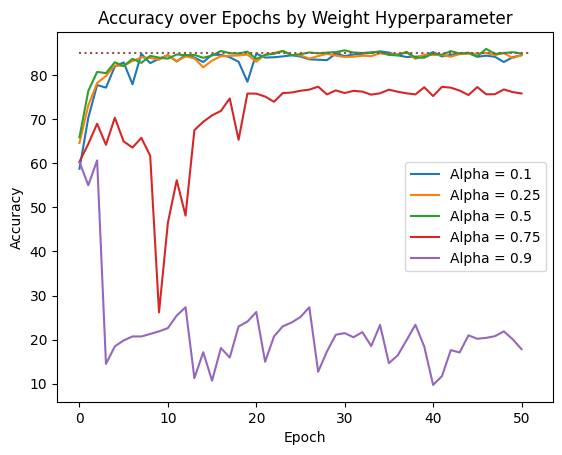

In [ ]:
sns.lineplot(x = range(len(test_accuracy_0_1)), y = test_accuracy_0_1, label = "Alpha = 0.1")
sns.lineplot(x = range(len(test_accuracy_0_25)), y = test_accuracy_0_25, label = "Alpha = 0.25")
sns.lineplot(x = range(len(new_test_accuracy)), y = new_test_accuracy, label = "Alpha = 0.5")
sns.lineplot(x = range(len(test_accuracy_0_75)), y = test_accuracy_0_75, label = "Alpha = 0.75")
sns.lineplot(x = range(len(test_accuracy_0_9)), y = test_accuracy_0_9, label = "Alpha = 0.9")
x = np.linspace(0, 51, 51)
y = np.full(51, 85)
plt.plot(x, y, linestyle = 'dotted')
plt.title('Accuracy over Epochs by Weight Hyperparameter')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('alphagraph.png',dpi = 800)